# Analysis of the Equation of State

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

A minimal set of reduced (averaged and processed) data files is included with the repository `../data/QMC.tar.bz2`.  We can extract if it hasn't already happened.

In [3]:
reduce_data = False
if not os.path.isdir('../data/QMC/'):
    ! tar xjf ../data/QMC.tar.bz2

## Some helper and analysis functions

In [4]:
import layerutils
from layerutils import lab,vals,texformat,get_base_dir

from pimcscripts import pimchelp

## Load QMC Data from Disk

In [5]:
num_sites = [24]
sim_params = {'T':0.0,'canonical':True,'τ':0.00313, 'β':0.5007}
Lz = np.array([5.05,10.0])

pimcid = defaultdict(dict)
par_map = defaultdict(dict)
base_dir = defaultdict(dict)
L,n,N,τ = defaultdict(dict),defaultdict(dict),defaultdict(dict),defaultdict(dict)
N_ads = defaultdict(dict)
simulations,pimcids = {},{}
pigs_pimcids,pimc_pimcids = defaultdict(list),defaultdict(list)

for cnum in num_sites:
    Nkey = lab(N=cnum)
    cbase_dir = get_base_dir(cnum,T=sim_params['T'])
    log_names = pimchelp.get_file_list_from_params(**sim_params,base_dir=cbase_dir)
        
     # We go through each file and automatically populate the simulation map
    for log in log_names:
        par_ = pimchelp.get_parameter_map(cbase_dir + log)

        cN = par_['Initial Number Particles']
        cf = cN/cnum

        sim = lab(T=sim_params['T'],n=cf,Lz=par_['Container Length'],N=cnum)
        base_dir[Nkey][sim] = cbase_dir
        
        # sort the pimcids into two possible groups
        pimcid[Nkey][sim] = par_['PIMCID']
        if sim_params['T'] > 0:
            pimc_pimcids[Nkey].append(par_['PIMCID'])
        else:
            pigs_pimcids[Nkey].append(par_['PIMCID'])

        par_map[Nkey][sim] = par_

        # We add some short-hand variables for ease of referencing
        L[Nkey][sim] = par_map[Nkey][sim]['Container Dimensions']
        n[Nkey][sim] = par_map[Nkey][sim]['Initial Density']
        N[Nkey][sim] = par_map[Nkey][sim]['Initial Number Particles']
        τ[Nkey][sim] = par_map[Nkey][sim]['Specified Imaginary Time Step']

    simulations[Nkey] = list(pimcid[Nkey].keys())
    pimcids[Nkey] = list(pimcid[Nkey].values())

## Generate the graphene lattice

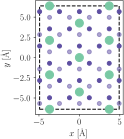

In [6]:
sim = simulations[lab(N=24)][0]
fix,ax = gt.plot_graphene_lattice_with_c_one_third(0.0,L[lab(N=24)][sim][:-1])

## Reduce All Data Files

In [7]:
if reduce_data:
    for cnum in num_sites[:]:
        print(f'=== N = {cnum} ===\n')
        reduce_command = f"parallel reduce-one.py -r T -i {{}} -s 0.8 --canonical {get_base_dir(cnum,T=sim_params['T'])} ::: {' '.join(pimcids[lab(N=cnum)])}"
        stream = os.popen(reduce_command)
        output = stream.read()
        print(output)

### Load the reduced estimators

In [8]:
estimator = {}
ρlin = {}
for cnum in num_sites:
    cNkey = lab(N=cnum)
    for sim in simulations[cNkey]:
        ckey = lab(N=cnum,Lz=vals(sim)['Lz'])

        reduce_params = {'canonical':True,'reduce':'T', 'pimcid':pimcid[cNkey][sim],'base_dir':base_dir[cNkey][sim]}
        estimator[sim] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params,estimator='estimator'))
        
        ρlin[sim] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params,estimator='lineardensity'))

In [9]:
filling = {}
est = {}

for cnum in num_sites:
    filling[lab(N=cnum)] = np.array([cn/cnum for cn in range(1,25)])
    for cLz in Lz:
        est[lab(N=cnum,Lz=cLz)] = defaultdict(list)
        for cf in filling[lab(N=cnum)]:
            sim = lab(N=cnum,n=cf,T=0.0,Lz=cLz)
            for cest_name in estimator[sim].data.dtype.names:
                est[lab(N=cnum,Lz=cLz)][cest_name].append(estimator[sim].data[cest_name])
                
        for cest_name in estimator[sim].headers:
            est[lab(N=cnum,Lz=cLz)][cest_name] = np.array(est[lab(N=cnum,Lz=cLz)][cest_name]) 

## The Equation of State

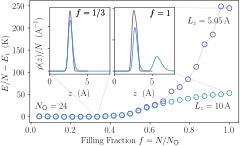

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from fractions import Fraction

shift = {}
for cnum in num_sites:
    for cLz in Lz:
        key = lab(N=cnum,Lz=cLz)
        shift[key]= est[key]['E/N'][0]

fig,ax = plt.subplots(figsize=(figsize[0],figsize[1]), constrained_layout=True)
axins1 = inset_axes(ax, width="80%", height="70%",
                    bbox_to_anchor=(.045, .2, .36, .78),
                    bbox_transform=ax.transAxes)

axins2 = inset_axes(ax, width="80%", height="70%",
                    bbox_to_anchor=(.355, .2, .36, .78),
                    bbox_transform=ax.transAxes)
axins = [axins1,axins2]
axins[0].set_xlabel(r'$\alabel{z}{\angstrom}$')
axins[1].set_xlabel(r'$\alabel{z}{\angstrom}$')
axins[0].set_ylabel(r'$\alabel{\rho(z)/N}{\angstrom^{-1}}$')

params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.5, 'ls':'--','mew':0.75}

for cnum in num_sites:
    for j,cLz in enumerate(Lz):
        for i,cf in enumerate([1/3,1]):
            sim = lab(N=cnum,T=0,n=cf,Lz=cLz)
            x,y,Δy = ρlin[sim].epdata(ρlin[sim].params[0])
            axins[i].plot(x+0.5*L[lab(N=cnum)][sim][-1],y/N[lab(N=cnum)][sim], lw=0.75, color=colors[j])
            axins[i].annotate(f'$f = {Fraction(cf).limit_denominator()}$', xy=(0.95,0.85),xytext=(0.95,0.85), 
                            xycoords='axes fraction', ha='right', va='bottom')

axins[1].set_yticklabels([])
axins[0].set_yticklabels([])
for i in range(2):
    axins[i].set_xlim(0,8)

for i,cLz in enumerate(Lz):
    ax.errorbar(filling[lab(N=24)],est[lab(N=24,Lz=cLz)]['E/N']-shift[lab(N=24,Lz=cLz)],
            yerr=est[lab(N=24,Lz=cLz)]['ΔE/N'],**params,
               label = f'$L_z = {cLz:.2f}\; \mathrm{{\AA}}$', color=colortools.get_alpha_hex(colors[i],0.5), 
               mec=colors[i])

#ax.legend(loc=(0.6,0.4),ncol=1)

ax.annotate("",
            xy=(1/3, 0.0), xycoords='data', zorder=-100,
            xytext=(0.4, 100), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':',alpha=0.5,lw=0.5),
            )

ax.annotate("",
            xy=(1/3, 0.0), xycoords='data',zorder=-100,
            xytext=(0.09, 98), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5),
            )

data_val = est[lab(N=24,Lz=10)]['E/N'][-1]-shift[lab(N=24,Lz=10)]
ax.annotate("",
            xy=(1, data_val), xycoords='data',zorder=-100,
            xytext=(0.72, 98), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5),
            )

data_val = est[lab(N=24,Lz=5.05)]['E/N'][-1]-shift[lab(N=24,Lz=5.05)]
ax.annotate("",
            xy=(1, data_val), xycoords='data',zorder=-100,
            xytext=(0.72, 246), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="arc3", color='gray', ls=':', alpha=0.5,lw=0.5),
            )

cnum=24
loc=(0.19,0.1)
ax.annotate(f'$N_\graphene = {cnum}$', xy=loc,xytext=loc, 
                            xycoords='axes fraction', ha='right', va='bottom')

loc=(0.98,0.1)
ax.annotate(r'$L_z = \SI{10}{\angstrom}$', xy=loc,xytext=loc, 
                            xycoords='axes fraction', ha='right', va='bottom')
loc=(0.98,0.8)
ax.annotate(r'$L_z = \SI{5.05}{\angstrom}$', xy=loc,xytext=loc, 
                            xycoords='axes fraction', ha='right', va='bottom')

ax.set_xlabel('Filling Fraction  $f = N/N_\graphene$')
ax.set_ylabel(r'$\alabel{E/N-E_1}{\kelvin}$');

plt.savefig('../plots/EoS_Teq0.pdf',dpi=300)
plt.savefig('../plots/EoS_Teq0.svg',dpi=300)

### How big is the raw offset between the curves?

In [11]:
Δ = shift[lab(N=24,Lz=10)] - shift[lab(N=24,Lz=5.05)]
print(f'Δ = {Δ:.2f} K')
print(f'Relative Shift = {100*Δ/est[lab(N=24,Lz=cLz)]["E/N"][0]:.1f}%')

Δ = -5.67 K
Relative Shift = 4.6%
